<a href="https://colab.research.google.com/github/parment1/Project-M1-M2/blob/main/Module_1_%26_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [193]:
import pandas as pd
import os
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from functools import reduce
from pandas.tseries.offsets import MonthEnd    

pd.set_option('display.max_rows',300)


Part I : Data acquisition, formating and cleaning

PART I project: Data acquisition, formating and cleaning

Dataset 1: Download the time series available on NASDAQ website for the Nasdaq Composite index, max history 2011 https://www.nasdaq.com/market-activity/index/ndx/historical

Dataset 2:

-GDP: We use GGP in percent change from preceding Period, quarterly, Seasonally Adjusted Annual Rate: Source: https://fred.stlouisfed.org/tags/series?t=quarterly

-CPI (consumer price inflation): Consumer Price Index: Growth Rate Same Period Previous Year, Monthly, Not Seasonally Adjusted. Source: https://fred.stlouisfed.org/tags/series?t=quarterly

-US Interest rates: Effective Federal Funds Rate, Percent, Monthly, Not Seasonally Adjusted. Source: https://fred.stlouisfed.org/series/FEDFUNDS

-US Unemployment rate Unemployment Rate, Percent, Monthly, Seasonally Adjusted. Source: https://fred.stlouisfed.org/series/UNRATE

Problem: Do we see a relationship between the stock market and macroeconomic variables


In [187]:
#Open each xls/csv
Nasdaq = pd.read_excel('/content/Nasdaq composite index.xlsx')
#CPI = Consumer price index
CPI = pd.read_excel('/content/CPI monthly.xls')
#Interest_rate = fed fund rate
Interest_rate = pd.read_excel('/content/Fed fund.xls')
GDP = pd.read_excel('/content/GDP.xls')
Unemployment = pd.read_excel('/content/Unemployment.xls')


Explore the strucutre of the different datasets. They all have different shape with monthly data for Unemployment CPI and interest rate, daily for Nasdaq and quarterly for GDP.

We add the monthly percentage change of the Nasdaq



In [188]:
#check size of each dataset
print([Nasdaq.shape,CPI.shape,Interest_rate.shape,GDP.shape,Unemployment.shape])

[(2557, 6), (464, 2), (806, 2), (297, 2), (884, 2)]


In [189]:
#Align the column name for all data set
Nasdaq = Nasdaq.rename(columns={'Date': 'observation_date'})

#Select columns Date & Close/Last date from Nasdaq dataset
Nasdaq = Nasdaq[['observation_date','Close/Last']]

#Get only monthly value for nadsqa (we can use either last day or first day of the month, need to be a trading day)
dates_month = pd.bdate_range(Nasdaq['observation_date'].min(), Nasdaq['observation_date'].max(), freq='1MS')

#Apply bdate range to the Nasdaq DF using isin
Nasdaq_mth = Nasdaq[Nasdaq['observation_date'].isin(dates_month)]
Nasdaq_mth.reset_index(inplace=True,drop=True)

#Calculate monthly return for the Nasdaq timeserie
Nasdaq_mth['Monthly return'] =  Nasdaq_mth['Close/Last'].pct_change()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Each dataset has a column "observation_date", with a different length. The maximum time length publicly available for download is 10 years, we do the following steps

1. we adjust the other data frame to this timeframe for each DF
2. Check the new shape of each DF
3. Merge the different DF into one
4. Simplify the name of the columns

In [190]:
#Select observation period, adjust starting/ending value for different periods

starting_date = '2012-01-01'
ending_date = '2021-07-01'

#Function to select obeservation period, df = dataframe

def select_date(df):
  x = df[(df['observation_date'] >= starting_date) & (df['observation_date'] <= ending_date)]
  x.reset_index(inplace=True,drop=True)
  return x

#Apply to the different dataframe using pipe and create new DF with selected time period
Nasdaq_sample, Interest_rate_sample, CPI_sample, GDP_sample,Unemployment_sample = (df.pipe(select_date)for df in [Nasdaq_mth, Interest_rate,CPI, GDP,Unemployment])

In [191]:
#Check size of dataset after transformation
print([Nasdaq_sample.shape,CPI_sample.shape,Interest_rate_sample.shape,GDP_sample.shape,Unemployment_sample.shape])

[(114, 3), (115, 2), (115, 2), (38, 2), (115, 2)]


In [255]:
data_frames = [Nasdaq_sample,CPI_sample,Interest_rate_sample,Unemployment_sample,GDP_sample]

#Merge all DF into one based on "observation date" using the function melt, keep N/A if any

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['observation_date'],
                                            how='left'), data_frames)

#drop the column Close/Last and set "observation date" as index
df_merged = df_merged.drop('Close/Last', axis = 1)
df_merged_clean = df_merged.set_index('observation_date')

#Simplify column name
columns = df_merged_clean.columns
columns

Index(['Monthly return', 'CPI',
       'Effective Federal Funds Rate, Percent, Monthly, Not Seasonally Adjusted',
       'Unemployment Rate, Percent, Monthly, Seasonally Adjusted',
       'Gross Domestic Product, Percent Change from Preceding Period, Quarterly, Seasonally Adjusted Annual Rate'],
      dtype='object')

In [246]:
df_merged_clean.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2021-07-01 to 2012-01-01
Data columns (total 5 columns):
 #   Column                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                    --------------  -----  
 0   Monthly return                                                                                            114 non-null    float64
 1   CPI                                                                                                       114 non-null    float64
 2   Effective Federal Funds Rate, Percent, Monthly, Not Seasonally Adjusted                                   114 non-null    float64
 3   Unemployment Rate, Percent, Monthly, Seasonally Adjusted                                                  114 non-null    float64
 4   Gross Domestic Product, Percent Change from Preceding Period, 

In [263]:
df_merged_clean.isna().sum()


Monthly return                                                                                               0
CPI                                                                                                          0
Effective Federal Funds Rate, Percent, Monthly, Not Seasonally Adjusted                                      0
Unemployment Rate, Percent, Monthly, Seasonally Adjusted                                                     0
Gross Domestic Product, Percent Change from Preceding Period, Quarterly, Seasonally Adjusted Annual Rate    77
dtype: int64


Part II: Descriptive analysis

-Check how dataset looks like
-Plot the different dataset
-Correlation matrix
-Cointegration matrix
-Test

Text(0.5, 1.0, 'Unemployment rate %')

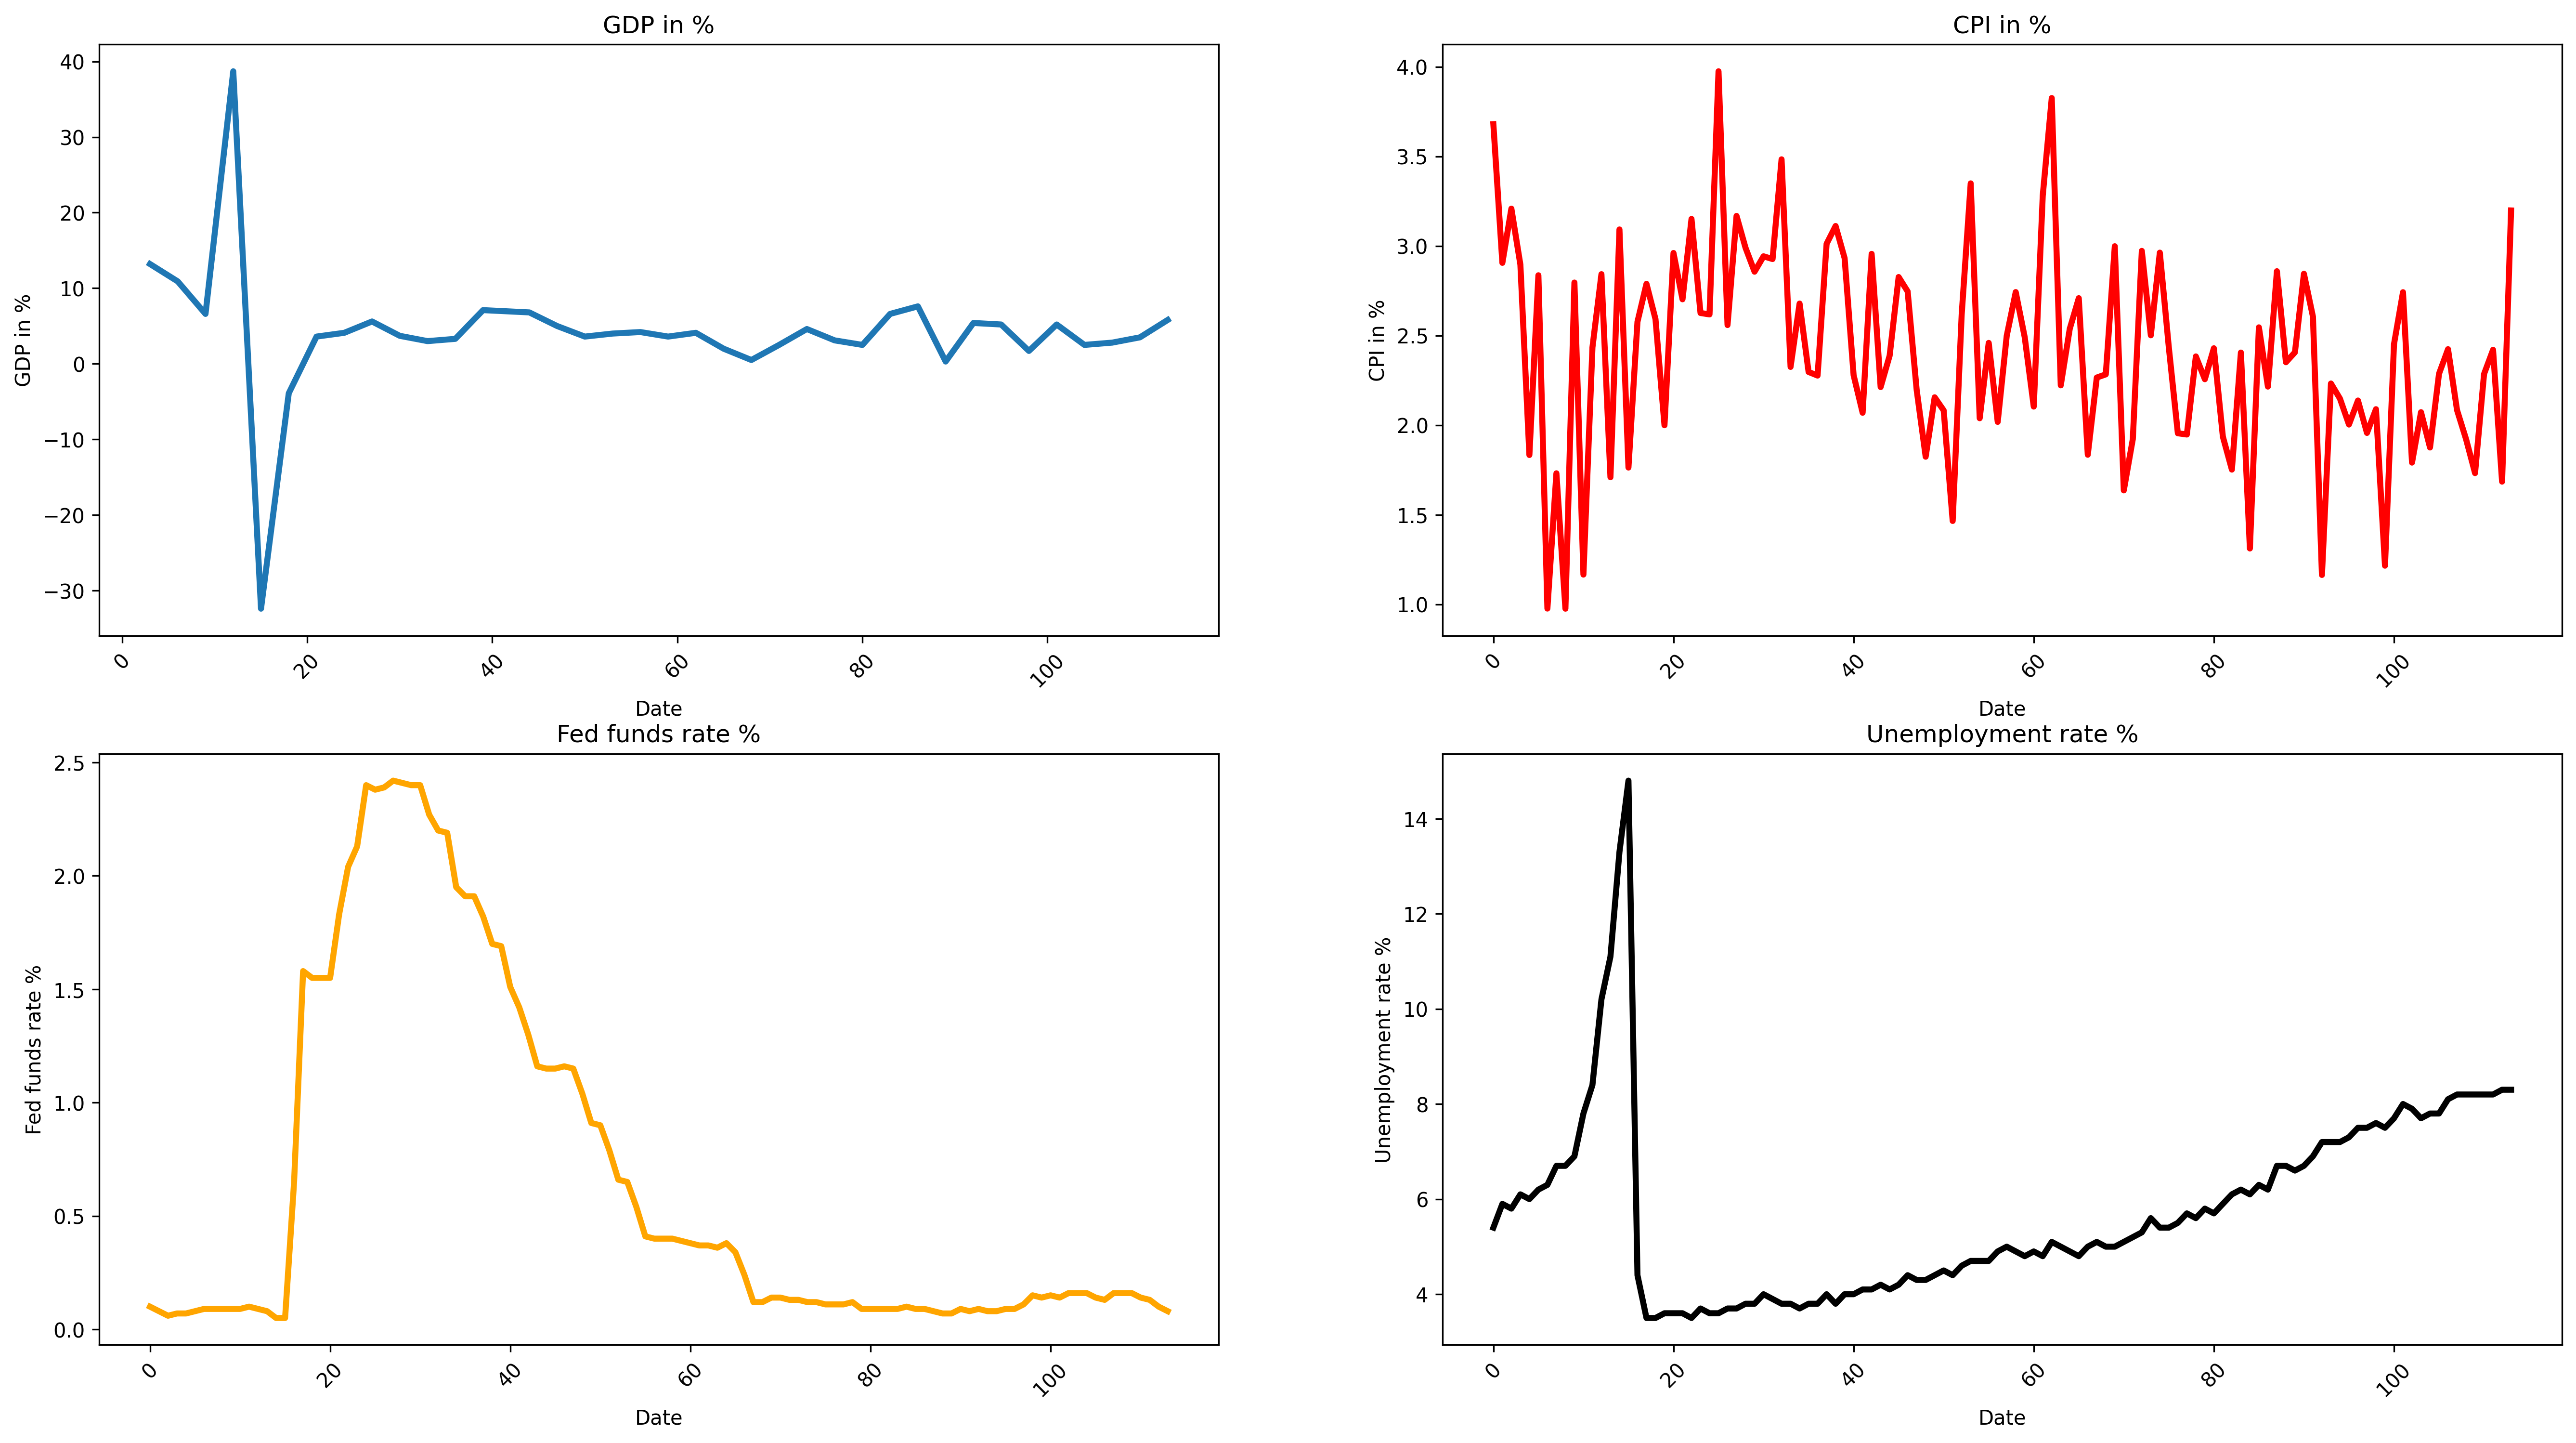

In [271]:
# Line plots
fig1 = plt.figure(figsize=(22, 10),dpi=300)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig1.add_subplot(221)
sns.lineplot(
    data=df_merged, 
#     kind="line",
    x=df_merged.index, 
    y="Gross Domestic Product, Percent Change from Preceding Period, Quarterly, Seasonally Adjusted Annual Rate",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('GDP in %')
plt.xlabel('Date')
plt.title('GDP in %')

ax2 = fig1.add_subplot(222)
sns.lineplot(
    data=df_merged, 
    x=df_merged.index, 
    y="CPI",
    ax = ax2,
    linewidth = 3,
    color = 'red')
plt.xticks(rotation=45) 
plt.ylabel('CPI in %')
plt.xlabel('Date')
plt.title('CPI in %')

ax3 = fig1.add_subplot(223)
sns.lineplot(
    data=df_merged, 
    x=df_merged.index, 
    y="Effective Federal Funds Rate, Percent, Monthly, Not Seasonally Adjusted",
    ax = ax3,
    linewidth = 3,
    color = 'orange')
plt.xticks(rotation=45) 
plt.ylabel('Fed funds rate %')
plt.xlabel('Date')
plt.title('Fed funds rate %')

ax4 = fig1.add_subplot(224)
sns.lineplot(
    data=df_merged, 
    x=df_merged.index, 
    y="Unemployment Rate, Percent, Monthly, Seasonally Adjusted",
    ax = ax4,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate %')
plt.xlabel('Date')
plt.title('Unemployment rate %')



In [211]:
df_merged_clean.describe()

,Monthly return,CPI,Interest rate,Unemployment rate,GDP quarterly rate
count,114.000000,114.000000,114.000000,114.000000,37.000000
mean,-0.015127,2.407017,0.648421,5.780702,4.232432
std,0.050382,0.572525,0.781848,1.978418,8.857265
min,-0.141301,0.975508,0.050000,3.500000,-32.400000
25%,-0.044247,2.046038,0.090000,4.225000,2.800000
50%,-0.018338,2.413311,0.155000,5.350000,4.000000
75%,0.011196,2.833864,1.150000,6.900000,5.600000
max,0.185898,3.974728,2.420000,14.800000,38.700000


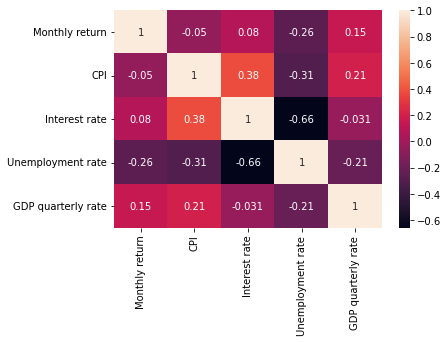

In [214]:
corrMatrix = df_merged_clean.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()